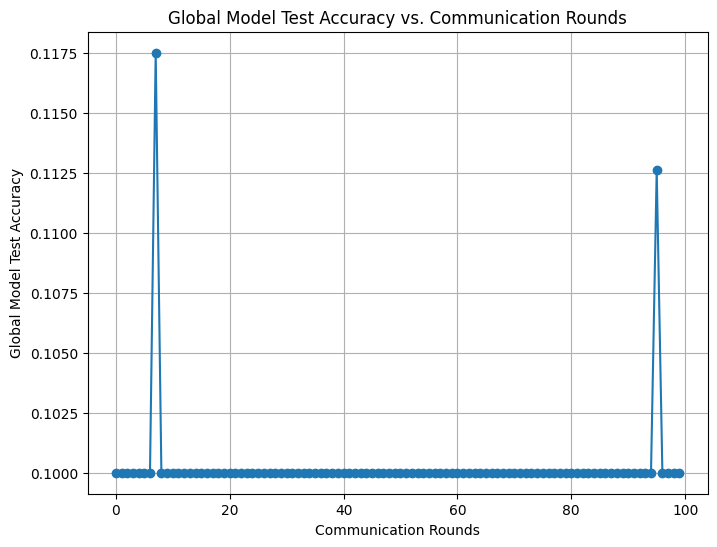

In [3]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store data
comm_rounds = []
test_accuracies = []

# Open and read the log file
LOG_FILE_PATH = './logs/'
with open(f"{LOG_FILE_PATH}experiment_log-alg=sflv1_partition=iid_lr=0.001_epochs=5_num_users=5_beta=0.01_batch_size=64_opt=adam_dataset=cifar10_2024-04-07-2046-38.log", "r") as file:
    log_content = file.read()

# Use regular expression to find the relevant data
pattern = r"in comm round:(\d+).*?>> Global Model Test accuracy: (\d+\.\d+)"
matches = re.findall(pattern, log_content, re.DOTALL)

# Extract communication rounds and test accuracies from the matches
for match in matches:
    comm_round = int(match[0])
    test_accuracy = float(match[1])
    comm_rounds.append(comm_round)
    test_accuracies.append(test_accuracy)

# Create the graph
plt.figure(figsize=(8, 6))
plt.plot(comm_rounds, test_accuracies, marker="o")
plt.xlabel("Communication Rounds")
plt.ylabel("Global Model Test Accuracy")
plt.title("Global Model Test Accuracy vs. Communication Rounds")
plt.grid(True)
plt.show()